In [ ]:
# Author: Sai Sri Surya Bandaru
# CSCE 5222 - Project 2
# Pancreatic Cancer Survival Analysis
# April 2024

In [10]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import joblib, os

In [13]:
# Setup paths

# Get the project root directory
BASE_DIR = Path(os.getcwd()).parent
DATA_DIR = BASE_DIR / "data"
MODEL_DIR = BASE_DIR / "models"

# Print paths to verify
print(f"Base directory: {BASE_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"Model directory: {MODEL_DIR}")

# Verify directories exist
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Load data function
def load_data(use_vae=False):
    file = "vae_augmented_data.csv" if use_vae else "synthetic_data.csv"
    return pd.read_csv(DATA_DIR / file)

# Build preprocessing pipeline
def build_preprocessor(df):
    num_cols = df.select_dtypes(include=["float64", "int64"]).columns.difference(["SurvivalMonths"])
    cat_cols = df.select_dtypes(include=["object"]).columns
    preproc = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ]
    )
    return preproc

Base directory: c:\Users\vckkr\OneDrive - Chaitanya UNT\OneDrive - UNT System\Documents\3rd-Party-Assignments\2025\04-April\CSCE 5222 - Project 2\Code
Data directory: c:\Users\vckkr\OneDrive - Chaitanya UNT\OneDrive - UNT System\Documents\3rd-Party-Assignments\2025\04-April\CSCE 5222 - Project 2\Code\data
Model directory: c:\Users\vckkr\OneDrive - Chaitanya UNT\OneDrive - UNT System\Documents\3rd-Party-Assignments\2025\04-April\CSCE 5222 - Project 2\Code\models


In [14]:
# Plot feature distributions
def plot_feature_distributions(df, title):
    num_cols = df.select_dtypes(include=["float64", "int64"]).columns.difference(["SurvivalMonths"])
    n_cols = 3
    n_rows = (len(num_cols) + n_cols - 1) // n_cols
    
    plt.figure(figsize=(15, 5*n_rows))
    for i, col in enumerate(num_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(data=df, x=col, kde=True)
        plt.title(f"{col} Distribution")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Plot survival by stage
def plot_survival_by_stage(df, title):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x="Stage", y="SurvivalMonths")
    plt.title(title)
    plt.xlabel("Cancer Stage")
    plt.ylabel("Survival Months")
    plt.show()

# Plot correlation heatmap
def plot_correlation(df, title):
    plt.figure(figsize=(12, 8))
    corr = df.select_dtypes(include=["float64", "int64"]).corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [15]:
# Train models and get scores
def train_models(df, use_vae=False):
    X = df.drop(columns="SurvivalMonths")
    y = df["SurvivalMonths"]

    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=df["Stage"]
    )

    pre = build_preprocessor(df)

    # Define models
    models = {
        "ElasticNet":  ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
        "SVR":         SVR(C=10, gamma="scale"),
        "DecisionTree":DecisionTreeRegressor(max_depth=5, random_state=42),
        "LightGBM":    LGBMRegressor(n_estimators=200, learning_rate=0.05),
        "XGBoost":     XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=4),
    }

    scores = {}
    for name, est in models.items():
        pipe = Pipeline([("prep", pre), ("model", est)])
        pipe.fit(Xtr, ytr)

        y_pred = pipe.predict(Xte)
        scores[name] = {
            "MAE": mean_absolute_error(yte, y_pred),
            "MSE": mean_squared_error(yte, y_pred),
        }

        # Save model
        out_dir = MODEL_DIR / "vae" if use_vae else MODEL_DIR
        out_dir.mkdir(parents=True, exist_ok=True)
        joblib.dump(pipe, out_dir / f"{name}_model.pkl")

    return pd.DataFrame(scores).T

In [17]:
# First, check if we need to generate the data
from src.synthetic_data import generate_original_data, generate_synthetic_patients

# Generate data if it doesn't exist
if not (DATA_DIR / "synthetic_data.csv").exists():
    print("Generating original dataset...")
    original_df = generate_original_data(1000)
    original_df.to_csv(DATA_DIR / "synthetic_data.csv", index=False)
    print("Original dataset saved")

if not (DATA_DIR / "vae_augmented_data.csv").exists():
    print("Generating VAE-augmented dataset...")
    vae_df = generate_synthetic_patients(original_df, 5000)
    vae_df.to_csv(DATA_DIR / "vae_augmented_data.csv", index=False)
    print("VAE-augmented dataset saved")

# Now load the data
print("Loading datasets...")
original_df = load_data(use_vae=False)
vae_df = load_data(use_vae=True)

# Run analysis
print("\nTraining on original data...")
original_scores = train_models(original_df, use_vae=False)
print("\nOriginal data scores:")
print(original_scores)

print("\nTraining on VAE data...")
vae_scores = train_models(vae_df, use_vae=True)
print("\nVAE data scores:")
print(vae_scores)

Generating original dataset...
Original dataset saved
Generating VAE-augmented dataset...
Epoch 20/150, Loss: 4.6211
Epoch 40/150, Loss: 4.4997
Epoch 60/150, Loss: 4.3596
Epoch 80/150, Loss: 4.3186
Epoch 100/150, Loss: 4.3031
Epoch 120/150, Loss: 4.2156
Epoch 140/150, Loss: 4.3525
VAE-augmented dataset saved
Loading datasets...

Training on original data...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 11
[LightGBM] [Info] Start training from score 10.872500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



Original data scores:
                   MAE         MSE
ElasticNet    7.964600  118.423290
SVR           7.738537  131.156999
DecisionTree  7.966413  119.455227
LightGBM      8.009767  121.171024
XGBoost       8.202568  129.234579

Training on VAE data...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 781
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 11
[LightGBM] [Info] Start training from score 10.630700


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



VAE data scores:
                   MAE        MSE
ElasticNet    3.331492  33.328017
SVR           2.629438  31.434395
DecisionTree  2.989129  31.189531
LightGBM      3.023969  31.146668
XGBoost       2.931231  29.087186


Original Data Visualizations:


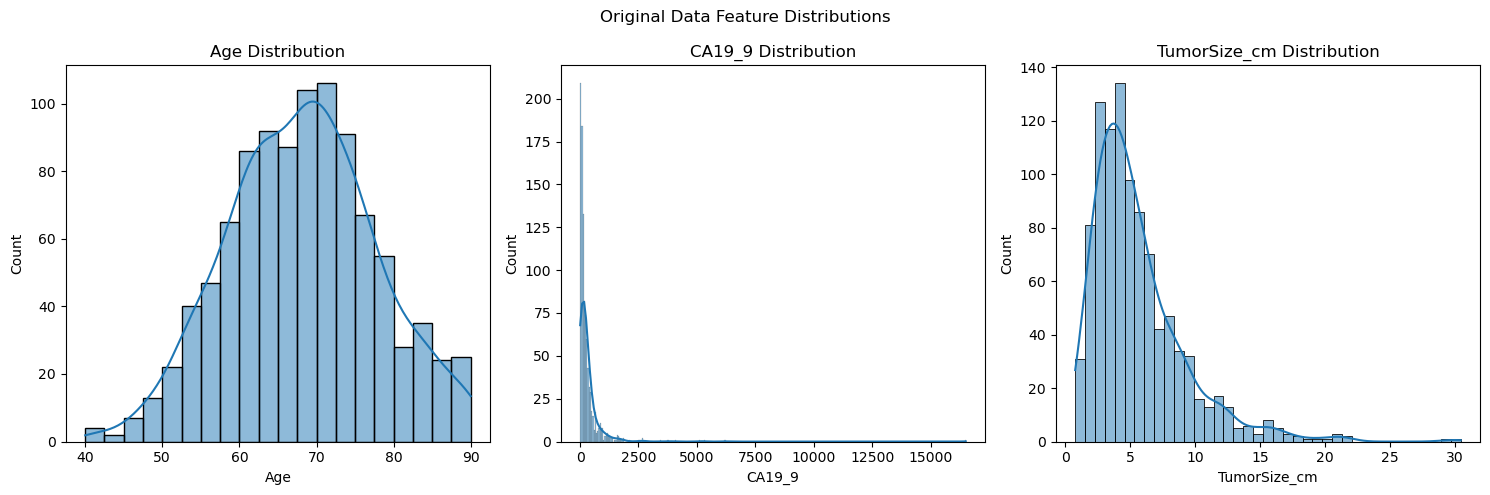

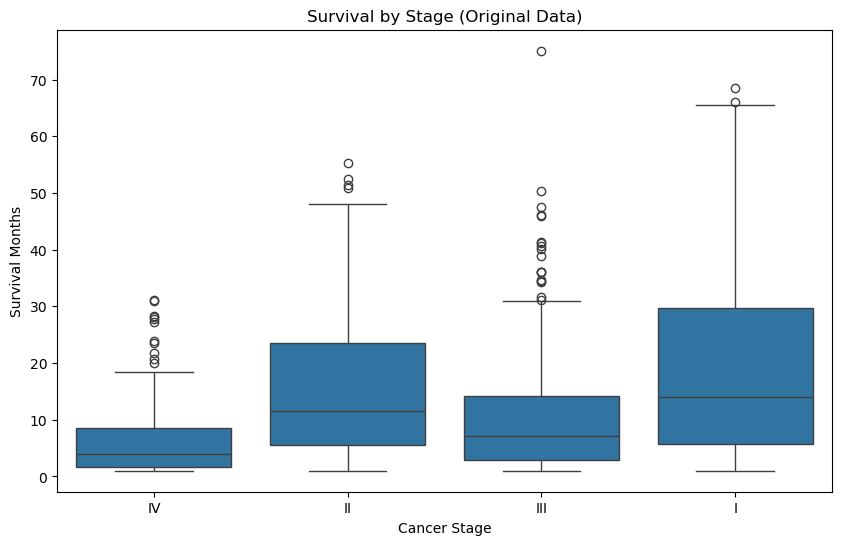

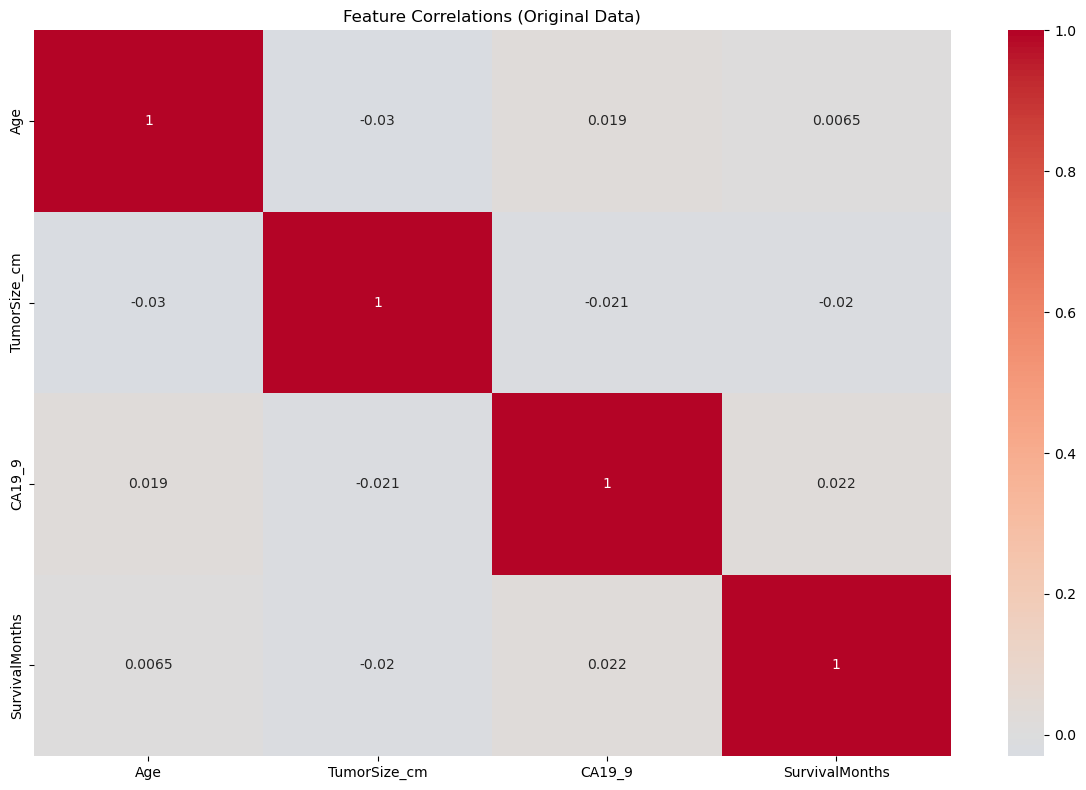


VAE-Augmented Data Visualizations:


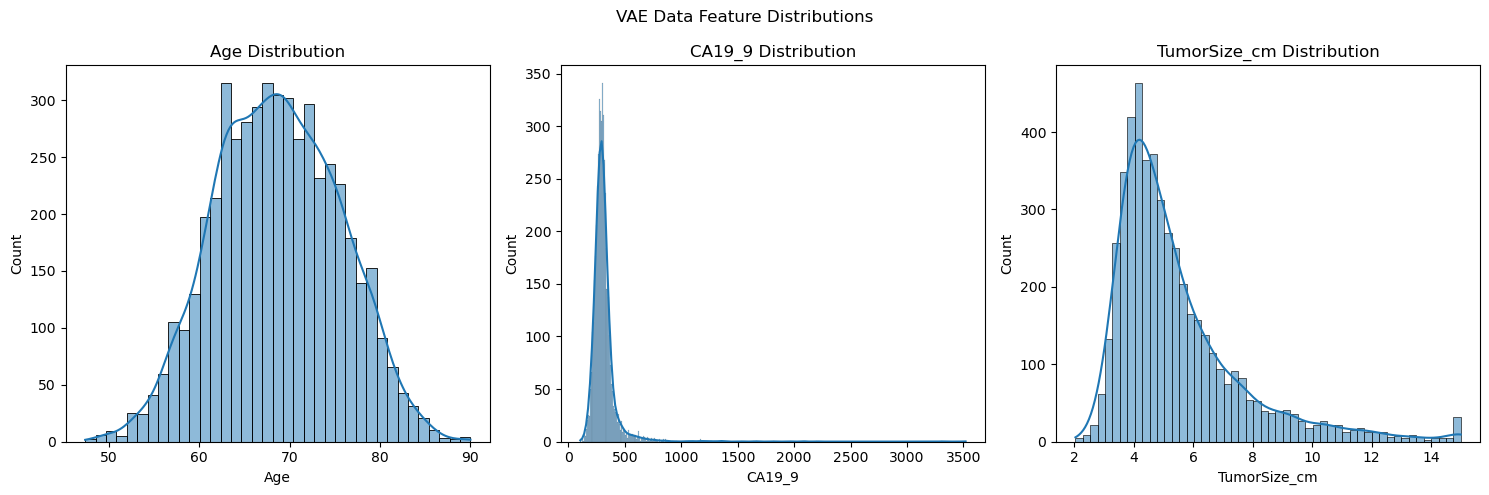

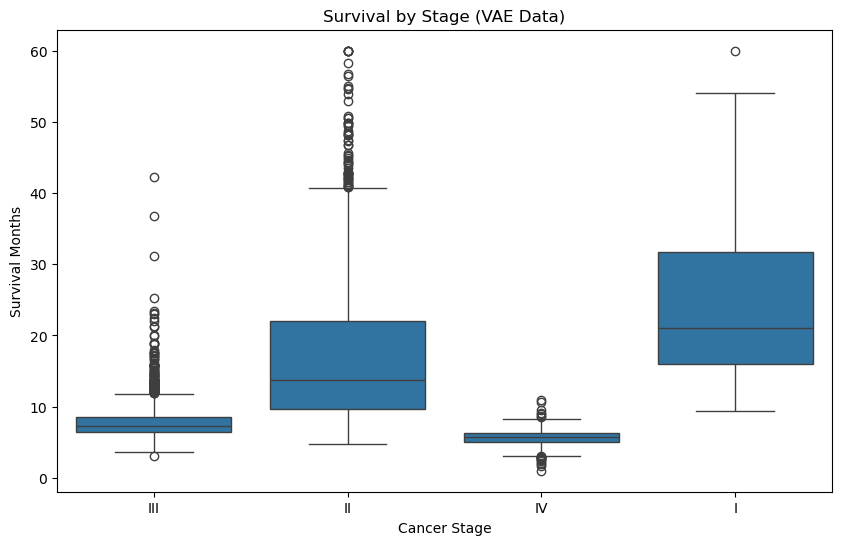

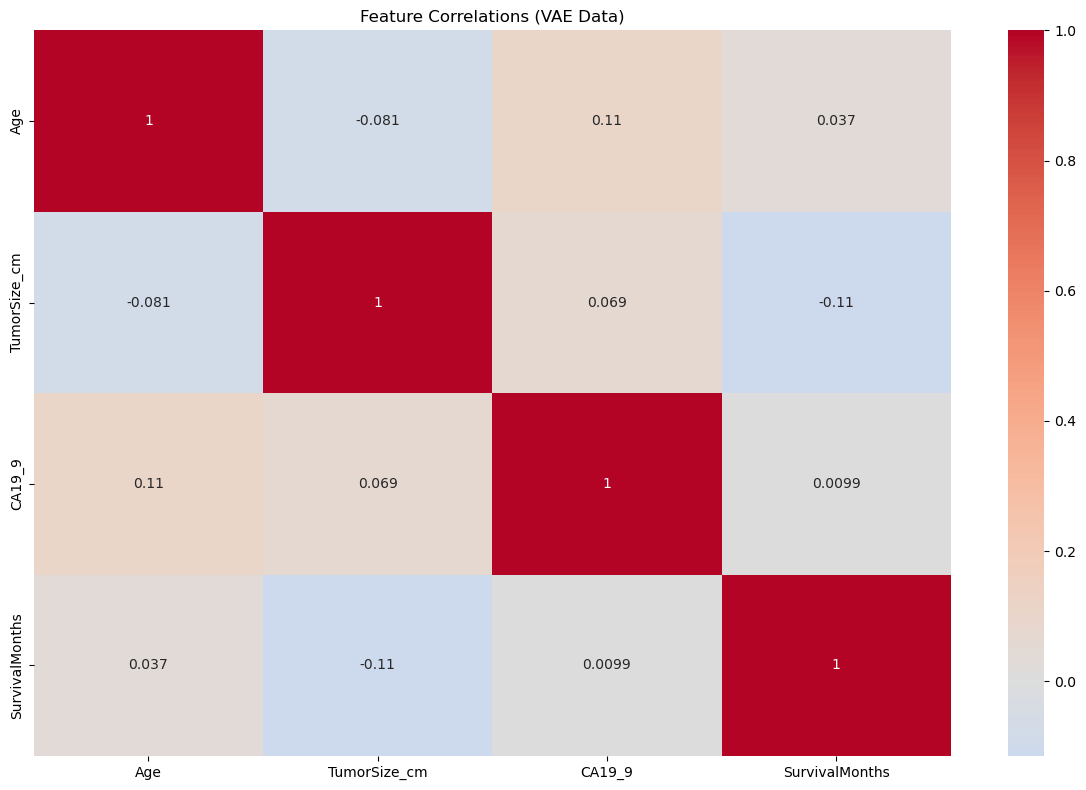

In [18]:
# Run visualizations for original data
print("Original Data Visualizations:")
plot_feature_distributions(original_df, "Original Data Feature Distributions")
plot_survival_by_stage(original_df, "Survival by Stage (Original Data)")
plot_correlation(original_df, "Feature Correlations (Original Data)")

# Run visualizations for VAE data
print("\nVAE-Augmented Data Visualizations:")
plot_feature_distributions(vae_df, "VAE Data Feature Distributions")
plot_survival_by_stage(vae_df, "Survival by Stage (VAE Data)")
plot_correlation(vae_df, "Feature Correlations (VAE Data)")

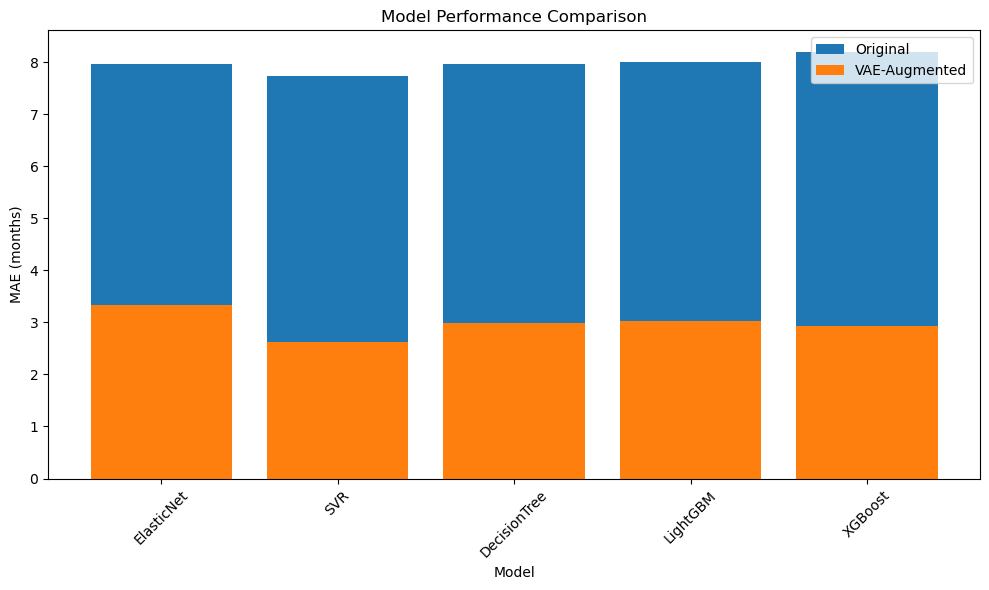

In [19]:
# Plot results
plt.figure(figsize=(10, 6))
plt.bar(original_scores.index, original_scores["MAE"], label="Original")
plt.bar(vae_scores.index, vae_scores["MAE"], label="VAE-Augmented")
plt.title("Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("MAE (months)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
# Detailed evaluation metrics
def print_detailed_metrics(scores_df, title):
    print(f"\n{title}")
    print("-" * 50)
    print("Mean Absolute Error (MAE):")
    print(scores_df["MAE"].sort_values())
    print("\nMean Squared Error (MSE):")
    print(scores_df["MSE"].sort_values())
    print("\nBest Model by MAE:", scores_df["MAE"].idxmin())
    print("Best Model by MSE:", scores_df["MSE"].idxmin())

# Print metrics for both datasets
print_detailed_metrics(original_scores, "Original Data Model Performance")
print_detailed_metrics(vae_scores, "VAE-Augmented Data Model Performance")

# Calculate improvement percentages
mae_improvement = ((original_scores["MAE"] - vae_scores["MAE"]) / original_scores["MAE"] * 100)
mse_improvement = ((original_scores["MSE"] - vae_scores["MSE"]) / original_scores["MSE"] * 100)

print("\nImprovement with VAE-Augmented Data:")
print("-" * 50)
print("MAE Improvement (%):")
print(mae_improvement.sort_values(ascending=False))
print("\nMSE Improvement (%):")
print(mse_improvement.sort_values(ascending=False))


Original Data Model Performance
--------------------------------------------------
Mean Absolute Error (MAE):
SVR             7.738537
ElasticNet      7.964600
DecisionTree    7.966413
LightGBM        8.009767
XGBoost         8.202568
Name: MAE, dtype: float64

Mean Squared Error (MSE):
ElasticNet      118.423290
DecisionTree    119.455227
LightGBM        121.171024
XGBoost         129.234579
SVR             131.156999
Name: MSE, dtype: float64

Best Model by MAE: SVR
Best Model by MSE: ElasticNet

VAE-Augmented Data Model Performance
--------------------------------------------------
Mean Absolute Error (MAE):
SVR             2.629438
XGBoost         2.931231
DecisionTree    2.989129
LightGBM        3.023969
ElasticNet      3.331492
Name: MAE, dtype: float64

Mean Squared Error (MSE):
XGBoost         29.087186
LightGBM        31.146668
DecisionTree    31.189531
SVR             31.434395
ElasticNet      33.328017
Name: MSE, dtype: float64

Best Model by MAE: SVR
Best Model by MSE: XGB

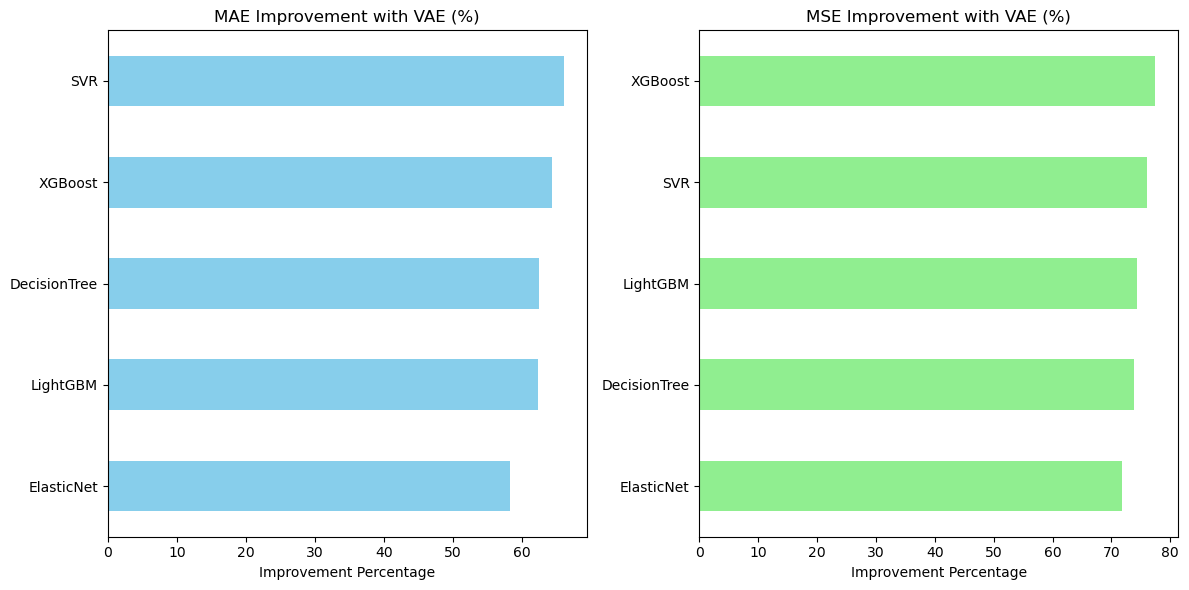

In [21]:
# Plot model performance improvement
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
mae_improvement.sort_values().plot(kind="barh", color="skyblue")
plt.title("MAE Improvement with VAE (%)")
plt.xlabel("Improvement Percentage")

plt.subplot(1, 2, 2)
mse_improvement.sort_values().plot(kind="barh", color="lightgreen")
plt.title("MSE Improvement with VAE (%)")
plt.xlabel("Improvement Percentage")

plt.tight_layout()
plt.show()

Model Performance Comparison

Best Model (Original Data): SVR
MAE: 7.74 months
MSE: 131.16

Best Model (VAE Data): SVR
MAE: 2.63 months
MSE: 31.43

Improvement with VAE: 66.0% reduction in MAE


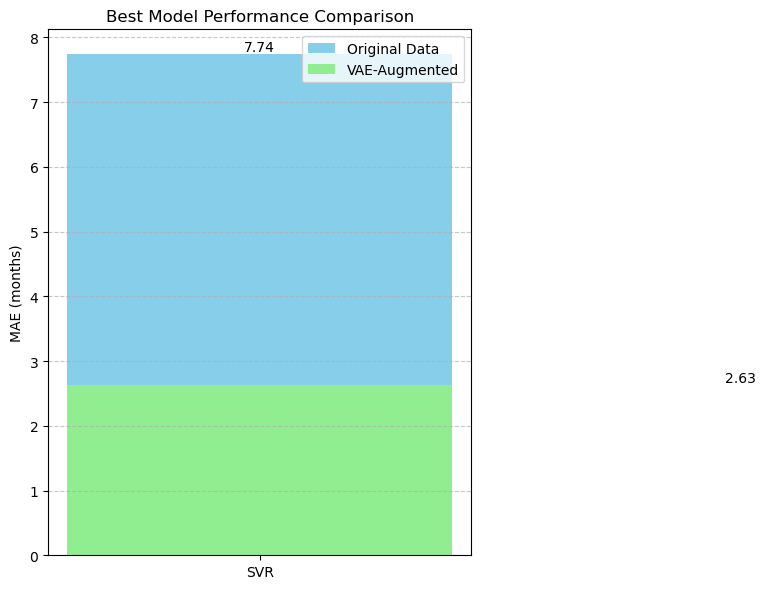

In [22]:
# Compare best models with and without VAE
print("Model Performance Comparison")
print("=" * 50)

# Find best models
best_original = original_scores["MAE"].idxmin()
best_vae = vae_scores["MAE"].idxmin()

print(f"\nBest Model (Original Data): {best_original}")
print(f"MAE: {original_scores.loc[best_original, 'MAE']:.2f} months")
print(f"MSE: {original_scores.loc[best_original, 'MSE']:.2f}")

print(f"\nBest Model (VAE Data): {best_vae}")
print(f"MAE: {vae_scores.loc[best_vae, 'MAE']:.2f} months")
print(f"MSE: {vae_scores.loc[best_vae, 'MSE']:.2f}")

# Calculate improvement
mae_improvement = ((original_scores.loc[best_original, "MAE"] - vae_scores.loc[best_vae, "MAE"]) 
                  / original_scores.loc[best_original, "MAE"] * 100)

print(f"\nImprovement with VAE: {mae_improvement:.1f}% reduction in MAE")

# Visual comparison
plt.figure(figsize=(10, 6))
models = [best_original, best_vae]
mae_values = [original_scores.loc[best_original, "MAE"], vae_scores.loc[best_vae, "MAE"]]
colors = ['skyblue', 'lightgreen']
labels = ['Original Data', 'VAE-Augmented']

plt.bar(models, mae_values, color=colors, label=labels)
plt.title("Best Model Performance Comparison")
plt.ylabel("MAE (months)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for i, v in enumerate(mae_values):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.legend()
plt.tight_layout()
plt.show()